In [20]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [3]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [4]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [5]:
# Print example tweet
print(f'What does one instance look like from the training set? \n\n{train_documents[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

Hargreaves Lansdown bucks weak markets to see assets rise 2.6 percent
...and here is its corresponding label 

2


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [6]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [7]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train_documents)
X_train = vectorizer.transform(train_documents)
X_val = vectorizer.transform(val_documents)
X_test_documents = vectorizer.transform(test_documents)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['$', 'aapl', 'news', 'be', 'become', 'very', 'bullish', 'again', 'http', ':']


In [8]:
# Checking full vocabulary size:
print(f' Full vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

 Full vocabulary size: 10616


              precision    recall  f1-score   support

           0       0.81      0.52      0.63        50
           1       0.56      0.16      0.25        31
           2       0.66      0.93      0.77        97

    accuracy                           0.68       178
   macro avg       0.67      0.54      0.55       178
weighted avg       0.68      0.68      0.64       178



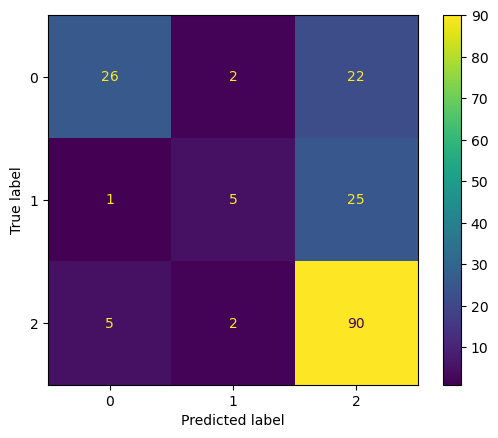

In [9]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [10]:
# Using POS-NEG lexicon features

In [11]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [12]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test_documents.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test_documents.multiply(lexicon_neg_scores), axis=1)

In [13]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test_documents = hstack((X_test_documents, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.83      0.48      0.61        50
           1       0.50      0.16      0.24        31
           2       0.65      0.93      0.76        97

    accuracy                           0.67       178
   macro avg       0.66      0.52      0.54       178
weighted avg       0.67      0.67      0.63       178



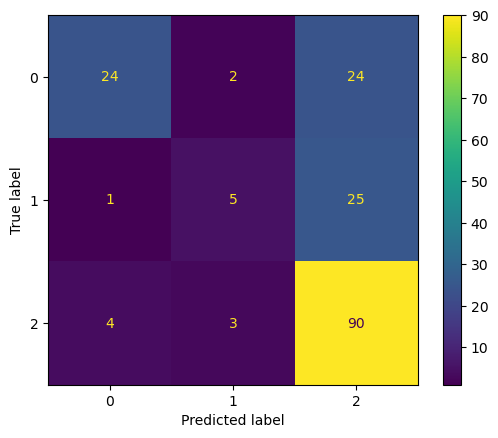

In [14]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [17]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the tweets where the classifier made an error:
tweets_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'Tweet: {tweets_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

Tweet: RT @StockTwits RT @fallondpicks Breadth Consolidates: After weeks of steady gains,advances in mkt breadth slowe... http://stks.co/2TrG $QQQ; true label = 1, prediction = 2.
Tweet: $MA http://stks.co/1CYN continues to consolidate / base here; true label = 1, prediction = 2.
Tweet: $AAPL 620 resistance area; true label = 1, prediction = 2.
Tweet: $WGO's BoD was right to reject the offer. That company is low because of the economy, not because of any type of mismanagement or anything.; true label = 1, prediction = 2.
Tweet: Arm slammed by handset sales outlook; true label = 0, prediction = 2.
Tweet: METALS-Zinc surges 12 pct after Glencore cuts output, fuelling metals rally; true label = 1, prediction = 0.
Tweet: Royal Mail chairman Donald Brydon set to step down; true label = 0, prediction = 1.
Tweet: #Apple breaks major support, here are some levels to watch - http://stks.co/jRmW $AAPL $QQQ; true label = 0, prediction = 2.
Tweet: Petrofac books further Â£30m cost for Shetland gas

# Performance on test set

              precision    recall  f1-score   support

           0       0.55      0.29      0.38        62
           1       0.71      0.26      0.38        39
           2       0.61      0.89      0.72       122

    accuracy                           0.61       223
   macro avg       0.62      0.48      0.49       223
weighted avg       0.61      0.61      0.57       223



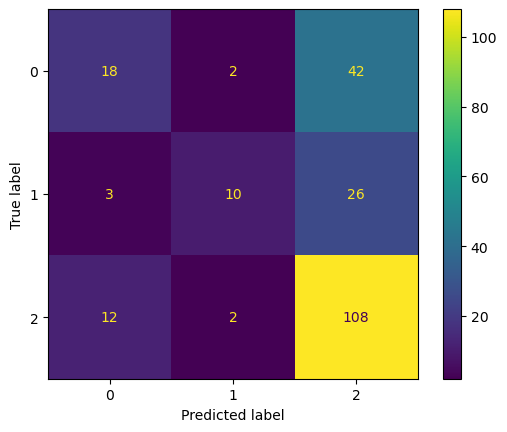

In [18]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test_documents)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [19]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels  # make sure the same proportion of labels is in the test set and training set
)

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

print(f'Number of training instances = {len(train_documents)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_documents)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [22]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train_documents:
    processed.append(preprocess(doc))
print(processed)

[['sophos', 'aim', 'raise', 'london', 'ipo'], ['rt', 'acinvestorblog', 'aapl', 'track'], ['companiesnew', 'aggreko', 'ceo', 'reshape', 'business', 'strip', 'cost'], ['complete', 'uk', 'largest', 'medically', 'underwrite', 'bulk', 'pension', 'risk', 'deal'], ['lloyds', 'bank', 'group', 'share', 'price', 'lift', 'amid', 'report', 'bank', 'poise', 'axe', 'hundreds', 'uk', 'job'], ['vxx', 'add', 'position'], ['juniper', 'tumble', 'warn', 'cisco', 'lower', 'jnpr', 'csco', 'https', 'bgvintk'], ['lloyds', 'cut', 'job', 'year', 'restructure', 'strategy'], ['tesco', 'share', 'price', 'steady', 'analysts', 'weigh', 'result'], ['hyg', 'potential', 'continuation', 'uptrend', 'chart', 'http', 'stks', 'qp'], ['glaxosmithkline', 'target', 'growth', 'units', 'scrap', 'viiv', 'ipo'], ['tesco', 'abandon', 'video', 'stream', 'ambition', 'blinkbox', 'sale'], ['bac', 'adsk', 'nflx', 'long', 'morning'], ['chrm', 'loooooongggggg', 'base'], ['look', 'like', 'big', 'feb', 'spread', 'cree', 'quarter', 'yoy', 'r

In [23]:
from gensim.corpora import Dictionary
# create a dictionary of word<->id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2268 unique tokens: ['aim', 'ipo', 'london', 'raise', 'sophos']...)


In [27]:
# Getting means of thetas

from gensim.matutils import any2sparse
from gensim.models import LdaModel

lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_tweet_topic_dists(train_documents, lda_model):
    thetas = []
    for i in range(len(train_documents)):
        # Get the tweet
        unseen_tweet = train_documents[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_tweet))

        # Let's get the topic distribution:
        theta_tweet = lda_model[bow_vector]

        thetas.append(theta_tweet)

    return thetas

thetas = get_tweet_topic_dists(train_documents, lda_model)

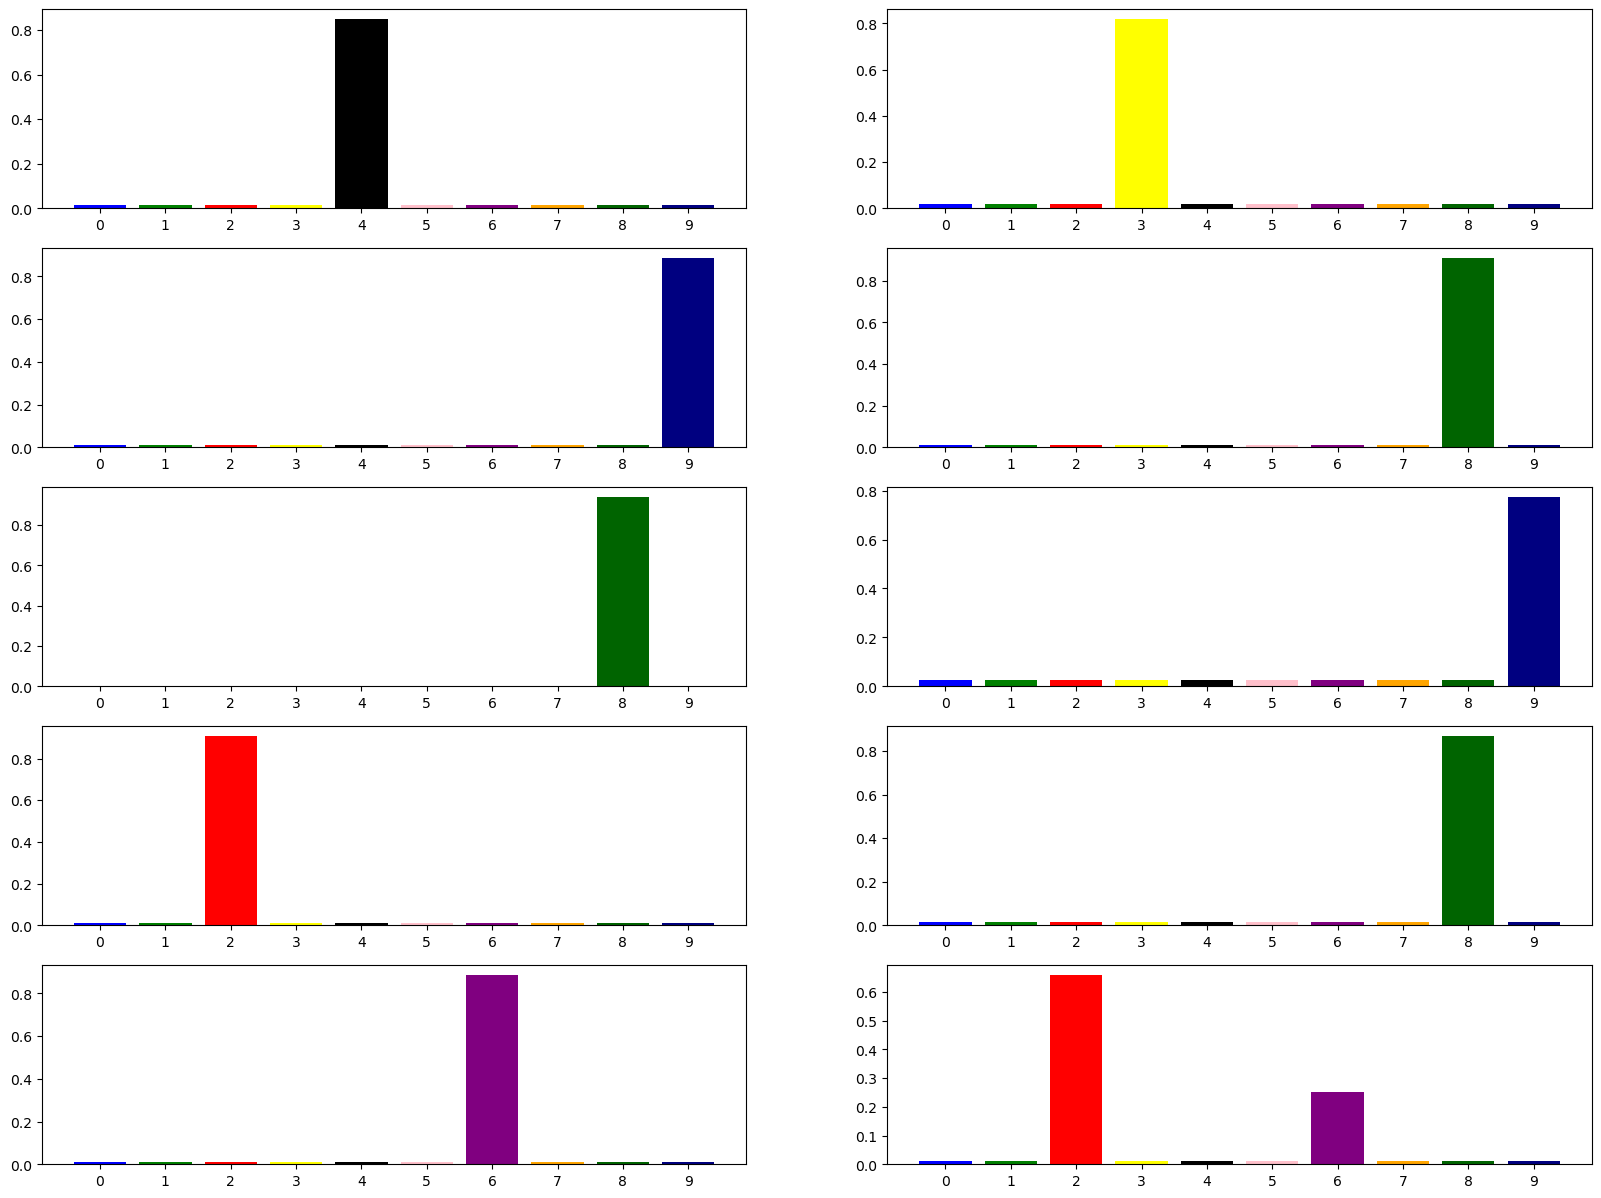

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)  # an empty array
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num_tweets, num_topics):
    plt.subplot(int((num_tweets+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))

plt.figure(figsize=(20,15))

num_tweets = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num_tweets, num_topics)
        counter +=1
plt.show()

In [43]:
# Merge arrays for later 
arr = train_documents
arr_2 = train_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['RT @ACInvestorBlog $AAPL still on track for $500' '1']
 ['CompaniesNew Aggreko CEO to reshape business, strip costs' '1']
 ['Tesco share price steady as analysts weigh in on results' '1']
 ['Tesco Abandons Video-Streaming Ambitions in Blinkbox Sale' '1']
 ['$AMZN Trailing 12 months operating cash flow rose 48% to $4.98 billion & free cash flow decreased 63% to $388 million http://stks.co/c06zG'
  '1']
 ['$AAPL AAPL finally breaking under the 49 M.A.. With no buybacks this week, look for AAPL to test the 120 support area.'
  '1']
 ['$CNP Sell Short Position on CNP,...Closed for Profit $ 59,367.00 (7.75%) http://stks.co/ghjc'
  '1']
 ["Insight hires Aviva's David Hillier for multi-asset team" '1']
 ['Morrisons finance chief to fill gap as CEO leaves early' '1']
 ['Horizonte acquires neighbouring Glencore nickel property in Brazil'
  '1']
 ['Diageo Sells Ryder Cup Venue Gleneagles Hotel to Ennismore Group' '1']
 ['FDA panel backs safety updates for AstraZeneca, Takeda drugs' '1']
 ["$X

In [47]:
# Show numbers till 8 decimal points for testing.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label, and each column to a topic.
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(train_documents[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

print(mean_arr.shape)

[0.09411474 0.08775121 0.12784178 0.08713732 0.11068884 0.11461427
 0.08731188 0.07279932 0.08923792 0.11227183]
[0.11602313 0.15224393 0.0625846  0.08938122 0.07971158 0.08636474
 0.10615828 0.05113056 0.11838806 0.11930542]
[0.08431036 0.09421539 0.1432608  0.09095744 0.10579642 0.08810923
 0.07789146 0.07803822 0.1107911  0.10645348]
(3, 10)
